# Wikidata Holy Wells Visualisation

This notebook fetches Holy Well data using a SPARQL query from Wikidata and creates charts.

## Define SPARQL query service

In [7]:
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Function to query Wikidata
def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

## Define the SPARQL Query

In [8]:
# SPARQL Query for Holy Wells and Their Etymologies
holyWellsQuery = """
SELECT ?etymology ?etymologyLabel (COUNT(?HW) AS ?count)
WHERE
{
  ?HW wdt:P31 wd:Q126443332.
  ?HW wdt:P131 wd:Q180231.
  ?HW wdt:P138 ?etymology.
  SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
GROUP BY ?etymology ?etymologyLabel
ORDER BY DESC(?count)
"""

## Fetch Data and Convert to DataFrame

In [9]:
# Fetch data using the SPARQL query
sparql_results = querySparql(holyWellsQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    data.append({
        "etymology": result['etymology']['value'],
        "etymologyLabel": result['etymologyLabel']['value'],
        "count": int(result['count']['value']),
    })

df = pd.DataFrame(data)
df

,etymology,etymologyLabel,count
0,http://www.wikidata.org/entity/Q345,Mary,23
1,http://www.wikidata.org/entity/Q2151232,townland,15
2,http://www.wikidata.org/entity/Q80979,Brigid of Kildare,11
3,http://www.wikidata.org/entity/Q165479,Saint Patrick,10
4,http://www.wikidata.org/entity/Q2280421,Ciarán of Saigir,10
...,...,...,...
75,http://www.wikidata.org/entity/Q170028,deception,1
76,http://www.wikidata.org/entity/Q466428,Philomena,1
77,http://www.wikidata.org/entity/Q6686215,Loughman,1
78,http://www.wikidata.org/entity/Q17590,Lawrence of Rome,1


## Visualise the Data with Charts

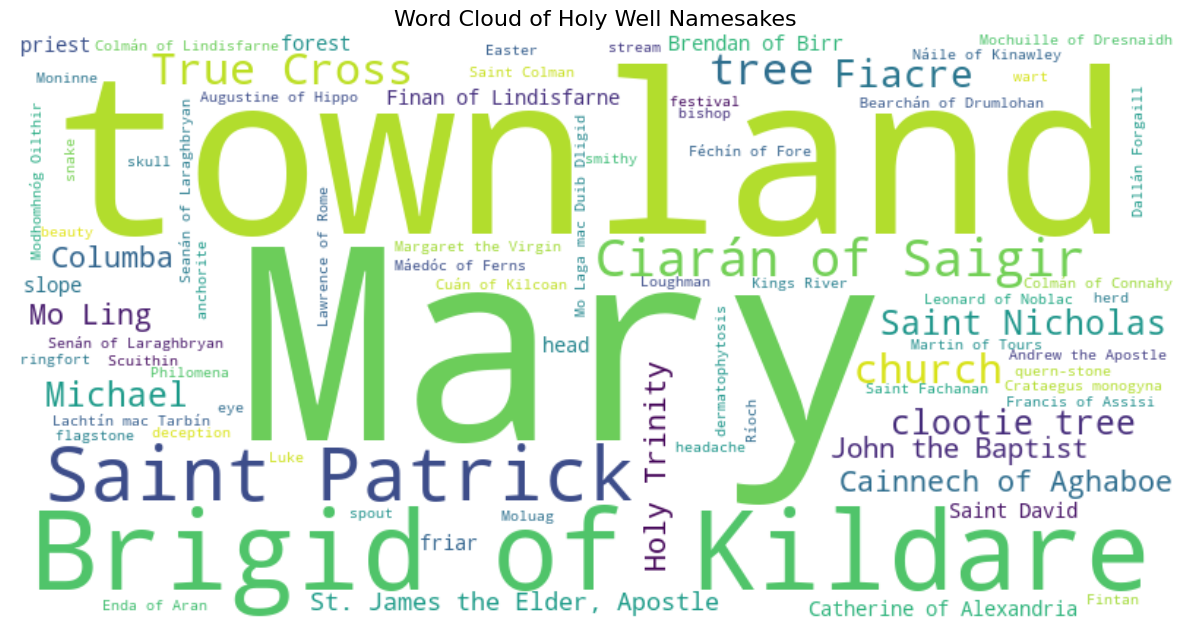

In [10]:
# Generate Word Cloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate_from_frequencies(
    dict(zip(df["etymologyLabel"], df["count"]))
)

plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Holy Well Namesakes", fontsize=16)
plt.tight_layout()
plt.show()

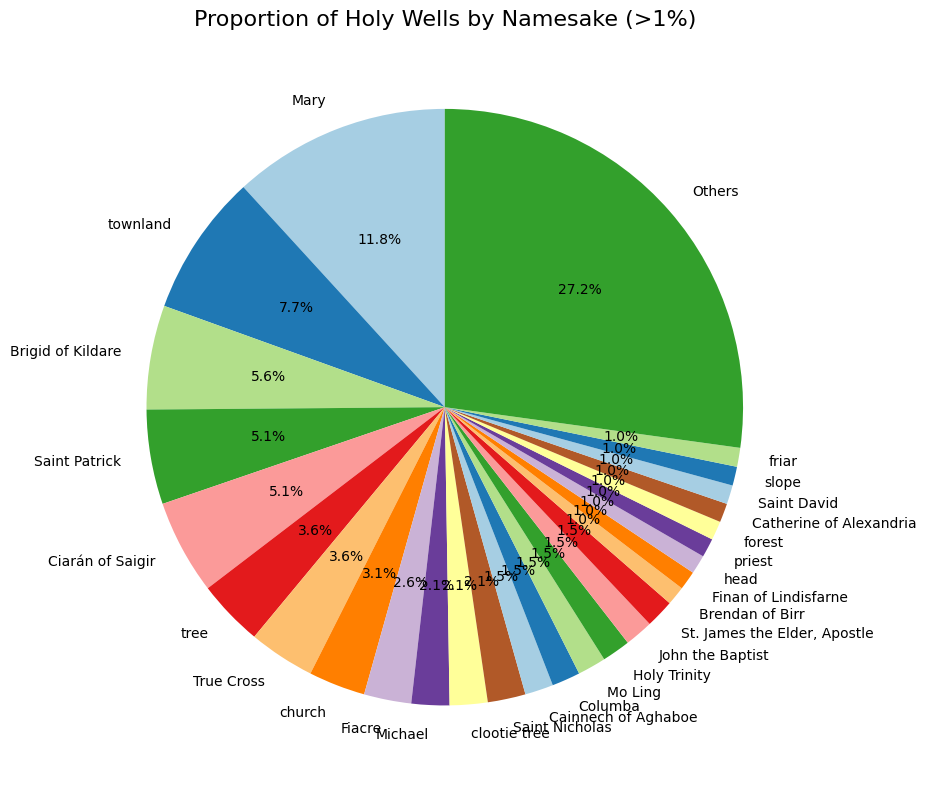

In [11]:
# Generate Pie Chart with Filtering
df_sorted = df.sort_values(by="count", ascending=False)
total_count = df_sorted["count"].sum()

# Filter namesakes > 1% and group the rest into "Others"
df_sorted["percentage"] = (df_sorted["count"] / total_count) * 100
df_filtered = df_sorted[df_sorted["percentage"] > 1]
others_count = df_sorted[df_sorted["percentage"] <= 1]["count"].sum()

# Add "Others" if applicable
if others_count > 0:
    df_filtered = pd.concat(
        [
            df_filtered,
            pd.DataFrame({"etymologyLabel": ["Others"], "count": [others_count], "percentage": [others_count / total_count * 100]})
        ]
    )

# Pie chart
plt.figure(figsize=(12, 8))
plt.pie(
    df_filtered["count"],
    labels=df_filtered["etymologyLabel"],
    autopct='%1.1f%%',
    startangle=90,
    colors=plt.cm.Paired.colors
)
plt.title("Proportion of Holy Wells by Namesake (>1%)", fontsize=16)
plt.tight_layout()
plt.show()